# Hear4U Model

**Hear4U** is an application that can help individuals with hearing disabilities to identify environmental sounds through visual speech recognition.

 ML Path:

- Muhammad Akram Fais (M281D4KY3193)
- Khairul Abdi (M281D4KY3168)
- Rakha Hanif Maheswara (M006D4KY1574)


## Import TensorFlow and other libraries


By installing `TensorFlow I/O`, you can load audio files easier.

In [ ]:
!pip install -q "tensorflow==2.11.*"
# tensorflow_io 0.28 is compatible with TensorFlow 2.11
!pip install -q "tensorflow_io==0.28.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 27.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires protobuf<5,>=3.20, but you have protobuf 3.19.6 which is incompatible.
pandas-gbq 0.19.2 requires google-auth-oauthlib>=0.7.0, but you have google-auth-oauthlib 0.4.6 which is incompatible.
tensorflow-datasets 4.9.5 requires protobuf>=

In [ ]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

## Loading YAMNet from TensorFlow Hub

We are going to use a pre-trained YAMNet from [Tensorflow Hub](https://tfhub.dev/) to extract the embeddings from the sound files.

In [ ]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [ ]:
from google.colab import files

# Mengunggah file
uploaded = files.upload()

# Mengambil nama file yang diunggah
for testing_filename in uploaded.keys():
    print(f'Nama file yang diunggah: {testing_filename}')

Saving 135527-6-4-0.wav to 135527-6-4-0.wav
Nama file yang diunggah: 135527-6-4-0.wav


The returned `wav_data` from `load_wav_16k_mono` is already normalized to values in the `[-1.0, 1.0]` range.

In [ ]:
@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

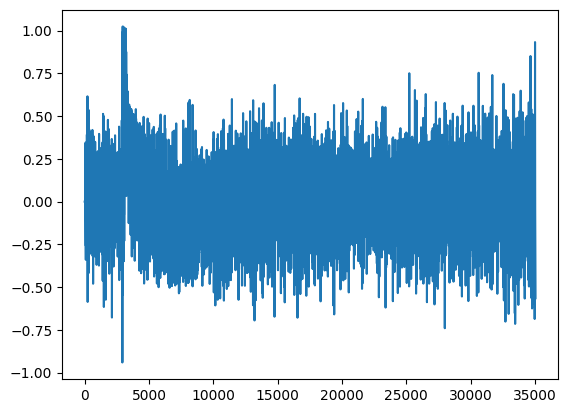

In [ ]:
testing_wav_data = load_wav_16k_mono(testing_filename)

_ = plt.plot(testing_wav_data)

# Play the audio file.
display.Audio(testing_wav_data, rate=16000)

### Load the class mapping

Load the class names that YAMNet is able to recognize.

In [ ]:
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

for name in class_names[:20]:
  print(name)
print('...')

Speech
Child speech, kid speaking
Conversation
Narration, monologue
Babbling
Speech synthesizer
Shout
Bellow
Whoop
Yell
Children shouting
Screaming
Whispering
Laughter
Baby laughter
Giggle
Snicker
Belly laugh
Chuckle, chortle
Crying, sobbing
...


### Run inference


In [ ]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.math.argmax(class_scores)
inferred_class = class_names[top_class]

print(f'The main sound is: {inferred_class}')

The main sound is: Explosion


## Hear4U dataset

The Hear4U dataset is a labeled collection of 1,000 environmental audio recordings. The dataset consists of 10 classes, with 100 examples per class.


Import Data from Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Showing the data

The metadata for each file is specified in the csv file at `./content/drive/MyDrive/Dataset/meta/hear4u.csv` and all the audio files are in `./content/drive/MyDrive/Dataset/meta/Hear4U/dataset_converted`

In [ ]:
hear4u = '/content/drive/MyDrive/Dataset/meta/hear4u.csv'
base_data_path = '/content/drive/MyDrive/Dataset/Hear4U_dataset_converted'

pd_data = pd.read_csv(hear4u)
pd_data.head()

,filename,fold,class_id,category
0,crying_baby_65.wav,1,0,crying_baby
1,3-151081-A-20.wav,1,0,crying_baby
2,crying_baby_8.wav,1,0,crying_baby
3,1-60997-A-20.wav,1,0,crying_baby
4,crying_baby4_35.wav,1,0,crying_baby


### Filter the data

We apply some transformations in the dataset:

- Filter out rows and use only the selected classes (`crying baby`, `door knock`, `glass_breaking`, `siren`, `car horn`, `door bells`, `rain`, `cat`, `dog` and `gun_shot`).
- Change the filename with the full path. This will make loading easier later.
- Change targets to be within a specific range (ID class).

In [ ]:
# my_classes = ['crying_baby', 'door_knock', 'glass_breaking', 'siren', 'car_horn', 'train',
#              'door_bells', 'cat', 'dog', 'gun_shot']
# map_class_to_id = {'crying_baby':0, 'door_knock': 1, 'glass_breaking': 2, 'siren': 3, 'car_horn': 4, 'train': 5,
#              'door_bells': 6, 'cat': 7, 'dog': 8, 'gun_shot': 9}
# filtered_pd = pd_data[pd_data.category.isin(my_classes)]

# class_id = filtered_pd['category'].apply(lambda name: map_class_to_id[name])
# filtered_pd = filtered_pd.assign(target=class_id)

full_path = pd_data['filename'].apply(lambda row: os.path.join(base_data_path, row))
pd_data = pd_data.assign(filename=full_path)

pd_data.head(10)

,filename,fold,class_id,category
0,/content/drive/MyDrive/Dataset/Hear4U_dataset_...,1,0,crying_baby
1,/content/drive/MyDrive/Dataset/Hear4U_dataset_...,1,0,crying_baby
2,/content/drive/MyDrive/Dataset/Hear4U_dataset_...,1,0,crying_baby
3,/content/drive/MyDrive/Dataset/Hear4U_dataset_...,1,0,crying_baby
4,/content/drive/MyDrive/Dataset/Hear4U_dataset_...,1,0,crying_baby
5,/content/drive/MyDrive/Dataset/Hear4U_dataset_...,1,0,crying_baby
6,/content/drive/MyDrive/Dataset/Hear4U_dataset_...,1,0,crying_baby
7,/content/drive/MyDrive/Dataset/Hear4U_dataset_...,1,0,crying_baby
8,/content/drive/MyDrive/Dataset/Hear4U_dataset_...,1,0,crying_baby
9,/content/drive/MyDrive/Dataset/Hear4U_dataset_...,1,0,crying_baby


### Load the audio files and retrieve embeddings

Apply the `load_wav_16k_mono` and prepare the WAV data for the model.

In [ ]:
filenames = pd_data['filename']
targets = pd_data['class_id']
folds = pd_data['fold']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
def load_wav_for_map(filename, label, fold):
  return load_wav_16k_mono(filename), label, fold

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label, fold):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

### Split the data

You will use the `fold` column to split the dataset into train, validation and test sets.

Hear4U Dataset is arranged into five uniformly-sized cross-validation `fold`s, such that clips from the same original source are always in the same `fold`.

The last step is to remove the `fold` column from the dataset since you're not going to use it during training.


In [ ]:
cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold < 4)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 4)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 5)

# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

## Create our model

In [ ]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(10)
], name='my_model')

my_model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dense_3 (Dense)             (None, 10)                5130      
                                                                 
Total params: 529,930
Trainable params: 529,930
Non-trainable params: 0
_________________________________________________________________


In [ ]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

In [ ]:
history = my_model.fit(train_ds,
                       epochs=20,
                       validation_data=val_ds,
                       callbacks=callback)

Epoch 1/20
212/212 [==============================] - 119s 300ms/step - loss: 0.7215 - accuracy: 0.8262 - val_loss: 0.4677 - val_accuracy: 0.8340
Epoch 2/20
212/212 [==============================] - 2s 9ms/step - loss: 0.3836 - accuracy: 0.8753 - val_loss: 0.4904 - val_accuracy: 0.8317
Epoch 3/20
212/212 [==============================] - 3s 13ms/step - loss: 0.3357 - accuracy: 0.8852 - val_loss: 0.5426 - val_accuracy: 0.8126
Epoch 4/20
212/212 [==============================] - 3s 13ms/step - loss: 0.3024 - accuracy: 0.8926 - val_loss: 0.5314 - val_accuracy: 0.8363
Epoch 5/20
212/212 [==============================] - 2s 8ms/step - loss: 0.2755 - accuracy: 0.9000 - val_loss: 0.4963 - val_accuracy: 0.8408
Epoch 6/20
212/212 [==============================] - 2s 8ms/step - loss: 0.2492 - accuracy: 0.9111 - val_loss: 0.4998 - val_accuracy: 0.8331
Epoch 7/20
212/212 [==============================] - 2s 8ms/step - loss: 0.2261 - accuracy: 0.9179 - val_loss: 0.5403 - val_accuracy: 0.8317


Run the `evaluate` method on the test data.

In [ ]:
loss, accuracy = my_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

63/63 [==============================] - 1s 9ms/step - loss: 0.6611 - accuracy: 0.8389
Loss:  0.6610701084136963
Accuracy:  0.8388554453849792


## Test your model

Next, try your model on the embedding from the previous test using YAMNet only.


In [ ]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
result = my_model(embeddings).numpy()

my_classes = ['crying_baby', 'door_knock', 'glass_breaking', 'siren', 'car_horn', 'train',
              'door_bells', 'cat', 'dog', 'gun_shot']

inferred_class = my_classes[result.mean(axis=0).argmax()]
print(f'The main sound is: {inferred_class}')

The main sound is: gun_shot


## Save a model that can directly take a WAV file as input

Your model works when you give it the embeddings as input.

In a real-world scenario, you'll want to use audio data as a direct input.

To do that, you will combine YAMNet with your model into a single model that you can export for other applications.

To make it easier to use the model's result, the final layer will be a `reduce_mean` operation. When using this model for serving (which you will learn about later in the tutorial), you will need the name of the final layer. If you don't define one, TensorFlow will auto-define an incremental one that makes it hard to test, as it will keep changing every time you train the model. When using a raw TensorFlow operation, you can't assign a name to it. To address this issue, you'll create a custom layer that applies `reduce_mean` and call it `'classifier'`.


In [ ]:
class ReduceMeanLayer(tf.keras.layers.Layer):
  def __init__(self, axis=0, **kwargs):
    super(ReduceMeanLayer, self).__init__(**kwargs)
    self.axis = axis

  def call(self, input):
    return tf.math.reduce_mean(input, axis=self.axis)

In [ ]:
saved_model_path = '/content/drive/MyDrive/model/hear4U_modelv3'

input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
embedding_extraction_layer = hub.KerasLayer(yamnet_model_handle,
                                            trainable=False, name='yamnet')
_, embeddings_output, _ = embedding_extraction_layer(input_segment)
serving_outputs = my_model(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)
serving_model = tf.keras.Model(input_segment, serving_outputs)
serving_model.save(saved_model_path, include_optimizer=False)

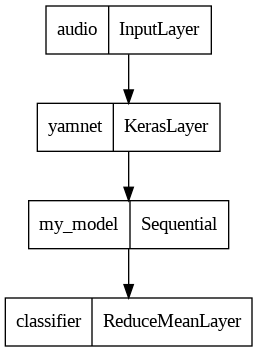

In [ ]:
tf.keras.utils.plot_model(serving_model)

Load our saved model to verify that it works as expected.

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

## Test model


/content/drive/MyDrive/Dataset/Hear4U_dataset_converted/174284-6-2-0.wav
Waveform values: [ 1.5890922e-09 -3.8605532e-09  8.7119263e-09 ...  1.5459393e-04
  1.5053833e-04  1.2412533e-04]


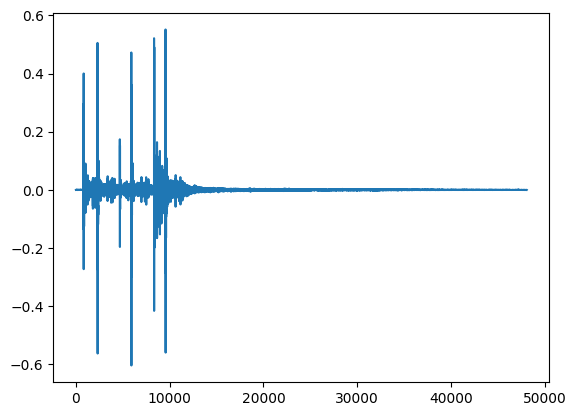

In [ ]:
test_pd = pd_data.loc[pd_data['fold'] == 5]
row = test_pd.sample(1)
filename = row['filename'].item()
print(filename)
waveform = load_wav_16k_mono(filename)
print(f'Waveform values: {waveform}')
_ = plt.plot(waveform)

display.Audio(waveform, rate=16000)

In [47]:
# Run the model, check the output.
reloaded_results = reloaded_model(waveform)
your_top_class = tf.math.argmax(reloaded_results)
your_inferred_class = my_classes[your_top_class]
class_probabilities = tf.nn.softmax(reloaded_results, axis=-1)
your_top_score = class_probabilities[your_top_class]
print(f'Predict with our model classes (labels). The sound is: {your_inferred_class} ({your_top_score})')

Predict with our model classes (labels). The sound is: gun_shot (0.9999970197677612)


In [48]:
# class_translation = {
#     'crying_baby': 'Bayi Menangis',
#     'door_wood_knock': 'Ketukan Pintu',
#     'glass_breaking': 'Pecahan Kaca',
#     'siren': 'Sirene',
#     'car_horn': 'Klakson Mobil',
#     'train': 'Kereta Api',
#     'church_bells': 'Lonceng Gereja',
#     'rain': 'Hujan',
#     'cat': 'Kucing',
#     'dog': 'Anjing'
# }

# Run the model to predict the label.
# reloaded_results = reloaded_model(waveform)
# your_top_class = tf.math.argmax(reloaded_results)
# your_inferred_class = my_classes[your_top_class]
# class_probabilities = tf.nn.softmax(reloaded_results, axis=-1)
# your_top_score = class_probabilities[your_top_class]

# Get the class name
# inferred_class_english = my_classes[your_top_class]

# Translate to Indonesian
# inferred_class_indonesian = class_translation[inferred_class_english]

# print(f'Predict the class: {inferred_class_indonesian}')